In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time #helper libraries

Using TensorFlow backend.


In [2]:
#Step 1 Load Data
#X_train, y_train, X_test, y_test = lstm.load_data('sp500.csv', 50, True)
X_train, y_train, X_test, y_test = lstm.load_data('m2.csv', 50, True)

In [3]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

# model.add(Dense(
#     output_dim=256))
# model.add(Activation('linear'))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mae', optimizer='adam')
print( 'compilation time : ', time.time() - start)

compilation time :  0.04877591133117676


In [4]:
## Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=64,
    nb_epoch=50,
    validation_split=0.05)

Train on 3307 samples, validate on 175 samples
Epoch 1/50
3307/3307 [==============================] - 10s 3ms/step - loss: 0.3735 - val_loss: 0.3689
Epoch 2/50
3307/3307 [==============================] - 7s 2ms/step - loss: 0.3711 - val_loss: 0.3636
Epoch 3/50
3307/3307 [==============================] - 7s 2ms/step - loss: 0.3676 - val_loss: 0.3591
Epoch 4/50
3307/3307 [==============================] - 7s 2ms/step - loss: 0.3652 - val_loss: 0.3540
Epoch 5/50
3307/3307 [==============================] - 7s 2ms/step - loss: 0.3607 - val_loss: 0.3527
Epoch 6/50
3307/3307 [==============================] - 7s 2ms/step - loss: 0.3553 - val_loss: 0.3427
Epoch 7/50
3307/3307 [==============================] - 7s 2ms/step - loss: 0.3258 - val_loss: 0.2767
Epoch 8/50
3307/3307 [==============================] - 7s 2ms/step - loss: 0.2564 - val_loss: 0.1986
Epoch 9/50
3307/3307 [==============================] - 7s 2ms/step - loss: 0.2406 - val_loss: 0.1896
Epoch 10/50
3307/3307 [===========

yo


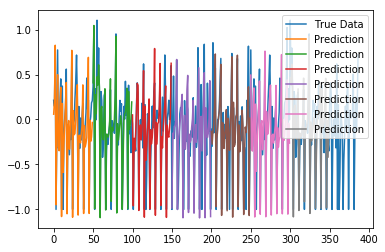

In [5]:
#Step 4 - Plot the predictions!
predictions = lstm.predict_sequences_multiple(model, X_test, 50, 50)
lstm.plot_results_multiple(predictions, y_test, 50)

In [13]:
pred = lstm.predict_sequence_full(model, X_test,10)
print(len(pred))

387
